# Implicit Neural Neural Representations

## Introduction

Implicit Neural Representations (INR) are a class of functions that model discrete signals as continuous by learning a representation that maps values directly from coordinate space. For instance, a colour image is a discrete signal of $(r, g, b)$ values that is defined by $(x,\ y)$ coordinates. An implict neural representation for an image is a function

\begin{align} f(x,\ y\ |\ \theta) → (r_{x, y},\ b_{x, y},\ g_{x, y}) \end{align}

with a maximum domain of $(height,\ width)$. Notably, the domain is of fixed size with discrete pixel intervals however the learned function $f(x,\ y\ |\ \theta)$ is continuous.

INRs have been used to map a variety of different data modalities, from images to audio to point clouds to 3D scenes. Popular examples of INRs include [Neural Radiance Fields (NeRFs)](https://arxiv.org/abs/2003.08934) and [Sinusoidal Representation Networks (SIRENs)](https://arxiv.org/abs/2006.09661). To my knowledge this is the first work that attempts to apply INRs to completely represent a neural network. I call this class of network an Implicit Neural Neural Representation, or INNR (pronounced inner). The goals of this work are as follows.
1. Identify the feasibility of representing neural network architectures as a continuous signal.
2. Explore the feasibility of INNR models as a form of network compression that does not require any training data other than the weights of the model itself.
3. Understand how INNR models may be vulnerable to evasion attacks from their original model.

This project was chosen as the code snippet for review for Christopher Wang's MILA application for Fall of 2024. Please see the **INNR Model Training** section for a strong example of novel scientific code. This project is ideal because of its limited scope, ease of readability, and interesting results. All experiments were conducted on Google Colab using a T4.


## Setup
Install necessary libraries, set the random seed and define hyperparameters

In [ ]:
# Download siren-pytorch for Pytorch Implementation of sinusoidal representation networks
%%capture
!pip install siren-pytorch

In [ ]:
# Import Libraries
import os
import random
from typing import Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from functorch import make_functional, FunctionalModule
import matplotlib.pyplot as plt

from siren_pytorch import SirenNet

In [ ]:
# Set the random seed for reproducibility
%%capture
seed = 1234
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Define Hyperparameters
args=dict()
args['epsilon']=0.3
args['model_batch_size']=512
args['model_epochs'] = 5
args['innr_epochs']=2000
args['lr'] =5e-4
args['verbose'] = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Generates an adversarial attack using the fast gradient sign method
def attack(model: nn.Module,
          device: torch.device,
          test_loader: DataLoader,
          criterion: nn.Module,
          epsilon=0.1):
  model = model.to(device)
  model.eval()
  attacks, targets = [], []
  for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    attack = data + epsilon * torch.sign(data.grad.data)
    attacks.append(attack)
    targets.append(target)
  return torch.concat(attacks), torch.concat(targets)

# Helper function to get trainable parameter counts
def parameter_count(model: nn.Module):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Helper function for generating line subplots
def create_line_subplot(ax: plt.Axes,
                        y_values: np.array,
                        x_label: str,
                        y_label: str,
                        title: str):
    ax.plot(y_values)
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    return

# Helper function for generating bar subplots
def create_bar_subplot(ax: plt.Axes,
                        keys: List[str],
                        values: List[float],
                        y_label: str,
                        title: str):
    ax.bar(keys, values)
    ax.set(ylabel=y_label, title=title)
    return

# Per epoch testing function, returns the average loss
def test(model: nn.Module,
        device: torch.device,
        test_loader: DataLoader,
        criterion: nn.Module) -> float:
  model.eval()
  losses = []
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      losses.append(criterion(output, target).item())
  avg_loss = np.array(losses).mean()
  return avg_loss

# Per epoch training function, returns the average loss
def train(model: nn.Module,
          device: torch.device,
          train_loader: DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: nn.Module) -> float:
  model = model.to(device)
  model.train()
  losses = []
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
  average_loss = np.array(losses).mean()
  return average_loss

# Regenerates a model parameters, returns a parameter tuple for an fmodel object
def predict_model_params(innr_model: nn.Module,
                        device: torch.device,
                        innr_loader: DataLoader,
                        params: Tuple[torch.Tensor]) -> Tuple[torch.Tensor]:
  innr_model.eval()
  flattened_params = []
  with torch.no_grad():
    for data, target in innr_loader:
      data, target = data.to(device), target.to(device)
      output = innr_model(data).flatten()
      output = innr_loader.dataset.inverse_standardize_weights(output)
      flattened_params.append(output)
  flattened_params = torch.concat(flattened_params)

  # Regenerate Shape from flat prediction
  layer_index = 0
  param_weights = []
  for p in params:
    param_slice = flattened_params[layer_index: layer_index+p.nelement()]
    param_weights.append(param_slice.view_as(p))
    layer_index += p.nelement()

  return tuple(param_weights)

# Per epoch functional testing function, using fmodel, returns the average loss
def fmodel_test(fmodel: FunctionalModule,
                new_params: Tuple[torch.Tensor],
                device: torch.device,
                test_loader: DataLoader,
                criterion: nn.Module) -> float:
  losses = []
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output =  fmodel(new_params, data)
      losses.append(criterion(output, target).item())
  avg_loss = np.array(losses).mean()
  return avg_loss

## MNIST Classifier Training
Train a basic Convolution Neural Network to serve as our target model to encode within an Implicit Neural Representation.

In [ ]:
class MnistExampleNet(nn.Module):
  """
  A simple convolutional network inspired by LeNet5 for MNIST classification

  Parameters:
      c (int): Number of channels in the first convolutional layer.
  """
  def __init__(self, c: int=32):
    super(MnistExampleNet, self).__init__()
    self.conv1 = nn.Conv2d(1, c, kernel_size=5, bias=False)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(c, c * 2, kernel_size=5, bias=False)
    self.fc1 = nn.Linear(c * 2 * 4 * 4, 10, bias=False)

  def forward(self, x):
    x = self.pool(F.sigmoid(self.conv1(x)))
    x = self.pool(F.sigmoid(self.conv2(x)))
    x = x.flatten(1)
    x = self.fc1(x)
    return x

In [ ]:
class Accuracy(nn.Module):
  """
  A simple criterion for calculating accuracy
  """
  def __init__(self):
    super(Accuracy, self).__init__()

  def forward(self, outputs: torch.Tensor, target: torch.Tensor):
    _, pred = torch.max(outputs, 1)
    correct = pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / target.numel()
    return torch.tensor(accuracy, dtype=torch.float32)

In [ ]:
# Download and prepare MNIST data
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_dataset = datasets.MNIST('./data', train=True, download=True, transform=mnist_transforms)
mnist_test_dataset = datasets.MNIST('./data', train=False, download=True, transform=mnist_transforms)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=args['model_batch_size'], shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=args['model_batch_size'], shuffle=False)

# Set up Mnist Model for training
mnist_model = MnistExampleNet()
mnist_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=args['lr'])
mnist_train_loss = nn.CrossEntropyLoss()
mnist_test_loss = Accuracy()

mnist_train_losses = np.zeros(args['model_epochs'])
mnist_test_losses = np.zeros(args['model_epochs'])

#Train the model
for epoch in range(args['model_epochs']):
  loss = train(mnist_model, device, mnist_train_loader, mnist_optimizer, mnist_train_loss)
  accuracy = test(mnist_model, device, mnist_test_loader, mnist_test_loss)

  mnist_train_losses[epoch] = loss
  mnist_test_losses[epoch] = accuracy

  if args['verbose']:
    print(f'Epoch: {epoch}\tAverage Train Loss: {loss:.5f}\tAverage Test Accuracy: {accuracy:.5f}')

Epoch: 0	Average Train Loss: 1.54766	Average Test Accuracy: 0.85048
Epoch: 1	Average Train Loss: 0.45776	Average Test Accuracy: 0.90745
Epoch: 2	Average Train Loss: 0.30113	Average Test Accuracy: 0.93127
Epoch: 3	Average Train Loss: 0.23057	Average Test Accuracy: 0.94563
Epoch: 4	Average Train Loss: 0.18622	Average Test Accuracy: 0.95562


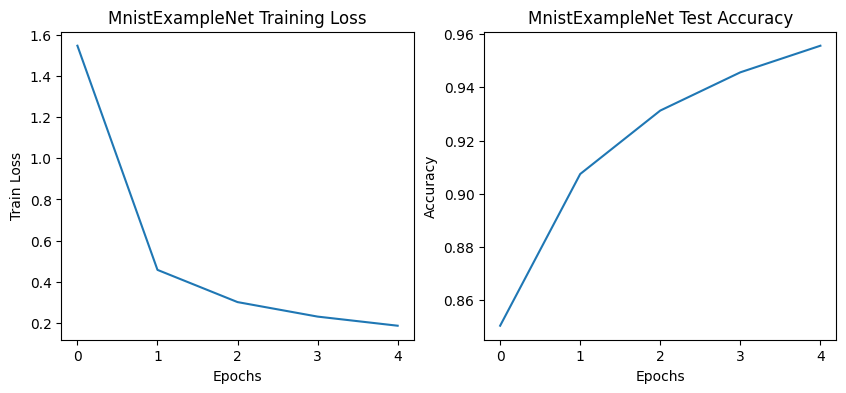

In [ ]:
#Visualize the loss curves of the train and test splits for the MnistExampleNet
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
create_line_subplot(axes[0], mnist_train_losses, 'Epochs', 'Train Loss', 'MnistExampleNet Training Loss')
create_line_subplot(axes[1], mnist_test_losses, 'Epochs', 'Accuracy', 'MnistExampleNet Test Accuracy')

## INNR Model Training
To begin, we must first decide on a coordinate scheme to train our INNR model. This is challenging as the dimensionality of a network changes depending on the type of layer: convolutional layers have 4 dimension , linear layers have 2 dimensions, and bias layers have a dimension of 1. The simplest mechanism to map these coordinates is to project the lower dimensional linear and bias layers as a hyperplane centered around the origin. Note that the domain varies significantly across layers, with  $(channel\ out, channel\ in, filter\ height, filter\ width)$ as the domain of convolutional layers, $(output,\ input)$ as the domain of linear layers, and $(output)$ as the domain of bias layers.

Therefore our coordinate scheme is as follows:
- $(layer,\ c_{out},\ c_{in}, w,\ h)$ for convolutional layers
- $(layer,\ out,\ in,\ 0,\ 0)$ for linear layers
- $(layer,\ out,\ 0,\ 0,\ 0)$ for bias layers (ommited for simplicity)

Given that the domain is variable across layers its likely that the manifold learned by the INNR model is more intricate compared to models dealing with consistent domains, such as images or audio. We normalize the domain of each dimension of a layer to $[-1,\ 1]$.

In [ ]:
class ConvCoordinateDataset(Dataset):
  """
  Dataset class for handling neural network coordinates and weights.

  Args:
    params (Tuple[torch.Tensor]): Tuple of parameter tensors
    standardize (bool): Flag indicating whether to standardize the weights.
  """
  def __init__(self, params: Tuple[torch.Tensor], standardize: bool = True):
    self.weights = self._flatten_params(params)
    self.coordinates = self._convert_to_coordinates(params)
    self.standardize = standardize
    if standardize:
      self.transformed_weights = self.standardize_weights()

  # Flatten the paramneter tuple
  def _flatten_params(self, params: Tuple[torch.Tensor]):
    flat_params = torch.concat([param.cpu().flatten() for param in params])
    return flat_params.view(-1, 1)

  # Translate convolutional params into normalized coordinates (cout, cin, h, w)
  def _conv_coordinates(self, param: torch.Tensor) -> torch.Tensor:
    conv_ranges = [torch.linspace(-1, 1, steps=size) for size in param.shape]
    mgrids = torch.meshgrid(*conv_ranges)
    normalized_coordinates = torch.stack(mgrids, dim=-1).reshape(-1, 4)
    return normalized_coordinates

  # Translate bias params into normalized coordinates (bias, 0, 0, 0)
  def _bias_coordinates(self, param: torch.Tensor) -> torch.Tensor:
    zeroes = torch.zeros(1)
    bias_ranges = torch.linspace(-1, 1, steps=param.shape[0])
    mgrids = torch.meshgrid(bias_ranges, zeroes, zeroes, zeroes)
    normalized_coordinates = torch.stack(mgrids, dim=-1).reshape(-1, 4)
    return normalized_coordinates

  # Translate linear parameters into normalized coordinates (out, in, 0, 0)
  def _lin_coordinates(self, param: torch.Tensor) -> torch.Tensor:
    zeroes = torch.zeros(1)
    lin_ranges = [torch.linspace(-1, 1, steps=size) for size in param.shape]
    mgrids = torch.meshgrid(*lin_ranges, zeroes, zeroes)
    normalized_coordinates = torch.stack(mgrids, dim=-1).reshape(-1, 4)
    return normalized_coordinates

  # Generate Coordinates with range [-1, 1] in form (layer, out, in, h, w)
  def _convert_to_coordinates(self, params: Tuple[torch.Tensor]):
    layer_coords = torch.linspace(-1, 1, steps=len(params))
    coordinates = []
    for param in params:
      if param.ndim == 4:
        coordinates.append(self._conv_coordinates(param))
      if param.ndim == 1:
        coordinates.append(self._bias_coordinates(param))
      if param.ndim == 2:
        coordinates.append(self._lin_coordinates(param))
    for i in range(len(params)):
      layer_coord = torch.full((len(coordinates[i]), 1), layer_coords[i])
      coordinates[i] = torch.concat([coordinates[i], layer_coord], -1)
    return torch.concat(coordinates)

  # Standardize outputs to improve training convergence
  def standardize_weights(self):
    mean, std = self.weights.mean(), self.weights.std()
    standardized_weights = (self.weights - mean) / std
    return standardized_weights

  # Reverse standardization for inference time
  def inverse_standardize_weights(self, weights: torch.Tensor):
    mean, std = self.weights.mean(), self.weights.std()
    standardized_weights = weights * std + mean
    return standardized_weights

  def __len__(self):
    return len(self.coordinates)

  def __getitem__(self, idx):
    weights = self.transformed_weights if self.standardize else self.weights
    return self.coordinates[idx], weights[idx]

The learned INNR model is of the form $f(l,\ out,\ in,\ x,\ y\ |\ \theta) → w_{(l,\ out,\ in,\ x,\ y)}$ where $w$ is the parameter at the given layer coordinates. I use the popular [SIREN](https://arxiv.org/abs/2006.09661) architecture for the INNR model due to its strong performance on a variety of representation tasks.

In [ ]:
# Generate INNR Data from MnistExampleNet model
model_param_count = parameter_count(mnist_model)
fmodel, params = make_functional(mnist_model, disable_autograd_tracking=True)
coordinate_dataset = ConvCoordinateDataset(params)
innr_loader = DataLoader(coordinate_dataset, batch_size=model_param_count, shuffle=False)
innr_testloader = DataLoader(coordinate_dataset, batch_size=model_param_count, shuffle=False)

# Define the training scheme
innr_model = SirenNet(
    dim_in = 5,
    dim_hidden = 64,
    dim_out = 1,
    num_layers = 12,
    final_activation = nn.Identity(),
    w0_initial = 100 * np.pi
)
innr_optimizer = torch.optim.Adam(innr_model.parameters(), lr=args['lr'])
innr_criterion = nn.MSELoss()

# Train the model, this can be an long process
test_modulo = 50
innr_train_losses = np.zeros(args['innr_epochs'])
innr_test_losses = np.zeros(args['innr_epochs']//test_modulo)
for epoch in range(args['innr_epochs']):
  loss = train(innr_model, device, innr_loader, innr_optimizer, innr_criterion)
  if epoch % test_modulo == 0:
    new_params = predict_model_params(innr_model, device, innr_loader, params)
    accuracy = fmodel_test(fmodel, new_params, device, mnist_test_loader, mnist_test_loss)
    innr_test_losses[epoch//test_modulo] = accuracy
    if args['verbose']:
      print(f'Epoch: {epoch}\tAverage Train Loss: {loss:.5f}\tAverage Test Accuracy: {accuracy:.5f}')
  innr_train_losses[epoch] = loss

/usr/local/lib/python3.10/dist-packages/torch/_functorch/deprecated.py:100: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.make_functional is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.functional_call instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('make_functional', 'torch.func.functional_call')
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 0	Average Train Loss: 1.28193	Average Test Accuracy: 0.10096
Epoch: 50	Average Train Loss: 0.89115	Average Test Accuracy: 0.08892
Epoch: 100	Average Train Loss: 0.73839	Average Test Accuracy: 0.14629
Epoch: 150	Average Train Loss: 0.55813	Average Test Accuracy: 0.35867
Epoch: 200	Average Train Loss: 0.40558	Average Test Accuracy: 0.76336
Epoch: 250	Average Train Loss: 0.30535	Average Test Accuracy: 0.82514
Epoch: 300	Average Train Loss: 0.23986	Average Test Accuracy: 0.85399
Epoch: 350	Average Train Loss: 0.20228	Average Test Accuracy: 0.89214
Epoch: 400	Average Train Loss: 0.16647	Average Test Accuracy: 0.91268
Epoch: 450	Average Train Loss: 0.15193	Average Test Accuracy: 0.92591
Epoch: 500	Average Train Loss: 0.13545	Average Test Accuracy: 0.92097
Epoch: 550	Average Train Loss: 0.11994	Average Test Accuracy: 0.92653
Epoch: 600	Average Train Loss: 0.10942	Average Test Accuracy: 0.92645
Epoch: 650	Average Train Loss: 0.10425	Average Test Accuracy: 0.93282
Epoch: 700	Average Trai

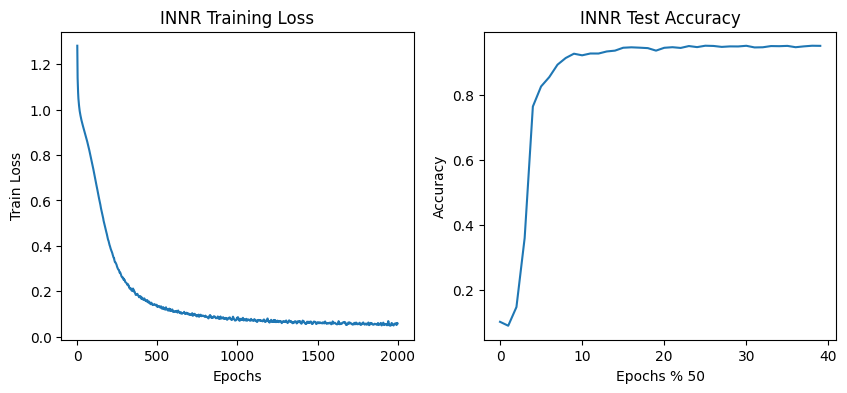

In [ ]:
#Visualize the loss curves of the train and test splits for the INNR model
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
_ = create_line_subplot(axes[0], innr_train_losses, 'Epochs', 'Train Loss', 'INNR Training Loss',)
_ = create_line_subplot(axes[1], innr_test_losses, f'Epochs % {test_modulo}', 'Accuracy', 'INNR Test Accuracy')

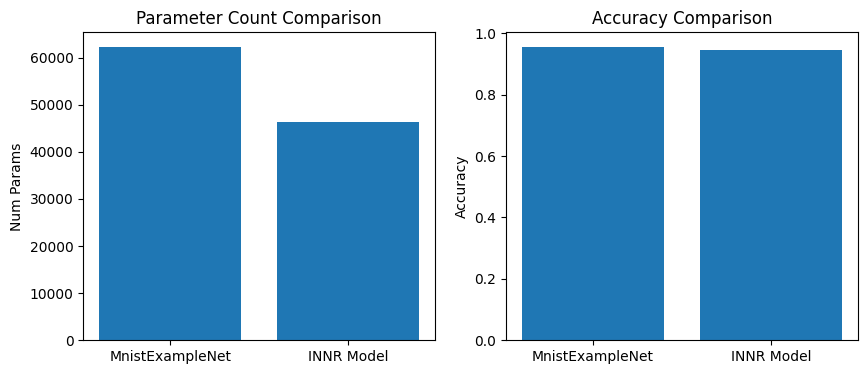

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
keys = ['MnistExampleNet', 'INNR Model']

innr_param_count = parameter_count(innr_model)
param_values = [model_param_count, innr_param_count]
_ = create_bar_subplot(axes[0], keys, param_values, 'Num Params', 'Parameter Count Comparison')

model_last_accuracy = mnist_test_losses[-1]
innr_last_accuracy = innr_test_losses[-20]
accuracy_values = [model_last_accuracy, innr_last_accuracy]
create_bar_subplot(axes[1], keys, accuracy_values, 'Accuracy', 'Accuracy Comparison')

## Attacking the INNR Model
As shown above the INNR model can be used as a form of model compression, having similar accuracies with ~74.2% of the parameters of the outer model. This means we may adequately represent a model as a continuous signal.

Here we do a small investigation into the susceptibility of the INNR model to adversarial attacks from the outer model. Since the expectation is that the INNR model predicts the parent model's parameters this should also mean it  inherits many of the same vulnerabilites of the loss landscape. For this task we use the Fast Gradient Sign Method to generate the adversarial attacks.

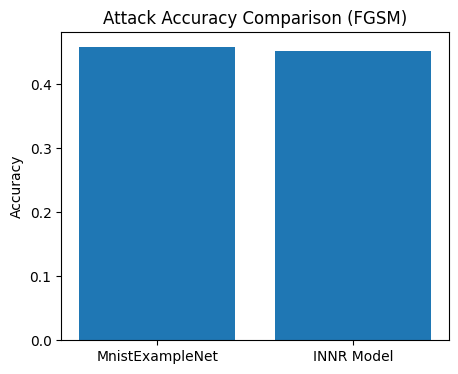

In [ ]:
# Generate attacks from base model
attacks, targets = attack(mnist_model, device, mnist_test_loader, mnist_train_loss, args['epsilon'])

# Get Accuracy from attacks
mnist_model_outputs = mnist_model(attacks)
innr_model_outputs = fmodel(new_params, attacks)
mnist_attack_accuracy = mnist_test_loss(mnist_model_outputs, targets)
innr_attack_accuracy = mnist_test_loss(innr_model_outputs, targets)

# Visualize the outputs
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
keys = ['MnistExampleNet', 'INNR Model']
attack_values = [mnist_attack_accuracy, innr_attack_accuracy]
_ = create_bar_subplot(ax, keys, attack_values, 'Accuracy', 'Attack Accuracy Comparison (FGSM)')